# Lab 9: non-linear curve fitting

In this lab we will look at how to fit a nonlinear model to a series of observed data points. This is one of the most common numerical tasks in science, and combines many of the different tasks we’ve seen in the module so far. Admittedly, this is also one of the most complex tasks we’ve yet attempted, so we’ll build it up step by step.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

The task we will set ourselves is to fit the peak in the following experimentally observed data set:

In [2]:
data_x = np.array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.])
data_y = np.array([10.6 , 16.  , 45.  , 83.5 , 52.8 , 19.9 , 10.8 ,  8.25,  4.7 ])

As always, it's a good idea to **start by plotting these data.**

<IPython.core.display.Javascript object>


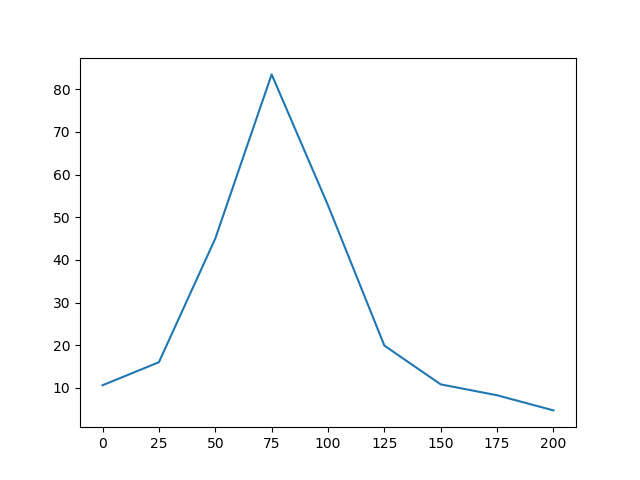

In [6]:
plt.plot(data_x, data_y)

The functional form we will fit is known as a *Lorentzian*, which takes the form

$$
L(x) = \frac{A}{(x - x_0)^2 + \gamma^2}.
$$

So here our parameters are $\mathbf{p} = (A, x_0, \gamma^2)$ which we will represent in Python by `param = (A, x0, gammasq)`.

Let’s begin by simply **defining a function to evaluate a Lorentzian**.

In [15]:
def lorentzian(x, param):
    """Calculates a Lorentzian function at x with parameters param = (A, x0, gamma)."""
    A, x0, gammasq = param
    return (A/ (((x - x0)**2) + gammasq))

**Check your answer by trying different values for `A`, `x0`, and `gammasq`; plot these curves on top of the data and try to get a reasonable fit “by hand”.**

*Hint:* $A$ is the “amplitude” of the curve and simply scales the function vertically; $x_0$ is the centre of the peak; and $\gamma$ is the half-width at half-maximum.

<IPython.core.display.Javascript object>


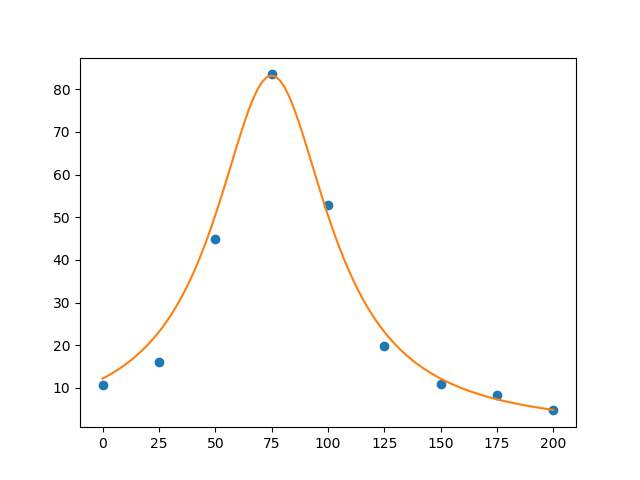

In [18]:
import numpy as np
x = np.linspace(0, 200, 100)
y = lorentzian(x, (80000,75,961))
plt.figure()
plt.plot(data_x, data_y, 'o')
plt.plot(x,y)
plt.show()

▶ **CHECKPOINT 1**

The next stage is to specify our function $\mathbf{g}(\mathbf{p})$. Recall from the notes that this has components

$$
g_j(p_1, p_2, \dots, p_q) = \sum_{i=1}^n\big(f(x_i) - y_i\big)\frac{\partial f}{\partial p_j}(x_i) \qquad 1\leq j \leq q
$$

or, to be specific for this case,

$$
g_j(p_1, p_2, p_3) = \sum_{i=1}^n\big(L(x_i) - y_i\big)\frac{\partial L}{\partial p_j}(x_i) \qquad j = 1, 2, 3
$$

where our three parameters $p_1 = A$, $p_2 = x_0$, and $p_3 = \gamma^2$.

We have to evaluate the partial derivatives by hand, but that isn’t difficult; for instance,

$$
\frac{\partial L}{\partial A} = \frac{1}{(x - x_0)^2 + \gamma^2}
$$

and so 

$$
g_1 = \sum_{i=1}^n\big(L(x_i) - y_i\big)\times\frac{1}{(x_i - x_0)^2 + \gamma^2}.
$$

I have written this term into the function below. **Complete it by adding similar terms for $g_2$ and $g_3$.**

In [19]:
def g(param, data):
    """Represents the vector function g derived from a Lorentzian for nonlinear least-squares fitting."""
    A, x0, gammasq = param
    x, y = data
    g1 = np.sum((y - lorentzian(x, param))/((x - x0)**2 + gammasq))
    g2 = np.sum((y - lorentzian(x, param))*((2*(x + x0)*A)/((x-x0)**2 + gammasq)**2))
    g3 = np.sum((y - lorentzian(x, param))*(A/((gammasq + (x-x0)**2)**2)))
    return g1, g2, g3

We now need to find the Jacobian matrix

$$
\frac{\partial\mathbf{g}}{\partial\mathbf{p}} = \begin{pmatrix}
        \frac{\partial g_1}{\partial p_1} & \frac{\partial g_1}{\partial p_2} & \dots & \frac{\partial g_1}{\partial p_q} \\
        \frac{\partial g_2}{\partial p_1} & \frac{\partial g_2}{\partial p_2} & \dots & \frac{\partial g_2}{\partial p_q} \\
        \vdots & \vdots & \ddots & \vdots \\
        \frac{\partial g_q}{\partial p_1} & \frac{\partial g_q}{\partial p_2} & \dots & \frac{\partial g_q}{\partial p_q} 
      \end{pmatrix}.
$$

Since this would be a pain to calculate by hand, we’ll do it numerically using the central difference method.

This is the trickiest part of these calculations to set up, so I have provided a function for you. **Check that you understand how it works.**

In [20]:
def CD(f, x0, h):
    """Returns the derivative of f at x0 evaluated using the central difference algorithm with step size h."""
    return (f(x0 + h/2) - f(x0 - h/2))/np.linalg.norm(h)

def jacobian(g, param, data):
    """Returns the Jacobian matrix of g evaluated at param, given observed data."""
    p = np.array(param)
    delta = 1e-6
    N = len(param)
    # Start with an empty matrix of the right size.
    jac = np.zeros((N,N))

    # We want to calculate df_i/dp_j for all i and j, so need two loops.
    for i in range(N):
        # Define an appropriate one-dimensional function f_i:
        def g_i(x):
            return g(x, data)[i]
        for j in range(N):
            # Set up a step of delta in the appropriate direction:
            dv = np.zeros(N)
            dv[j] = delta
            
            jac[i,j] = CD(g_i, p, dv)
            
    return jac

To test the Jacobian code, we’ll evaluate the Jacobian of a simple function:

$$
\mathbf{f}(x, y) = (2x - y, xy).
$$

**Complete the following Python code to define this function.** (Note that, for consistency with the rest of our code, we need a `data` argument even though obviously this particular function doesn’t depend on our experimental data.)

In [21]:
def f(param, data):
    x, y = param
    return (2*x - y, x*y)

**Calculate the Jacobian by hand. Then evaluate the Jacobian at several $(x,y)$ points, using the code above, and check you get the right answers.** (Again, you will need to pass a `data` argument to `jacobian`; this can be whatever you like, say `None`. An example is given below.)

In [22]:
jacobian(f, (2,3), None)

array([[ 2., -1.],
       [ 3.,  2.]])

▶ **CHECKPOINT 2**

Finally, we can put all of this code together to use in the multidimensional Newton-Raphson method. Recall, again from the notes, that at each step we replace $\mathbf{p}$ by

$$
      \mathbf{p}-\left(\frac{\partial\mathbf{g}}{\partial\mathbf{p}}\right)^{-1}\mathbf{g}(\mathbf{p}).
$$

**Complete the definition of the `nD_Newton_step` function below to return this value.** Remember that the multiplication here is a matrix multiplication; you will need to use one the methods to solve matrix equations you learned in the previous lab. (Either will do.)

In [23]:
def nD_Newton_step(g, p, data):
    j = jacobian(g, p, data)
    x = np.linalg.solve(j, g(p, data))
    return p - x

We have now completed the code needed to do a nonlinear least-squares fit! Try it out by **starting with a suitable guess for the parameters, and iterating Newton-Raphson steps** just as we did in the 1D case. **Plot your best-fit results along with the data.**

In [24]:
p0 = (60000,70,625)
eps = 1e-7
converged = False
while not converged:
    p1 = nD_Newton_step(g, p0, (data_x, data_y))
    print(p1)
    if np.linalg.norm(p1 - p0) < eps:
        converged = True
        print(p1)
    else:
        p0 = p1

[65296.37461762    73.46271064   749.1135159 ]
[67838.2885696     76.77617252   801.55558101]
[66919.75049645    77.48992428   789.41504433]
[66886.35852118    77.49358031   788.8832983 ]
[66886.38989121    77.49357897   788.88385761]
[66886.38989133    77.49357897   788.88385761]
[66886.38989133    77.49357897   788.88385761]
[66886.38989133    77.49357897   788.88385761]


<IPython.core.display.Javascript object>


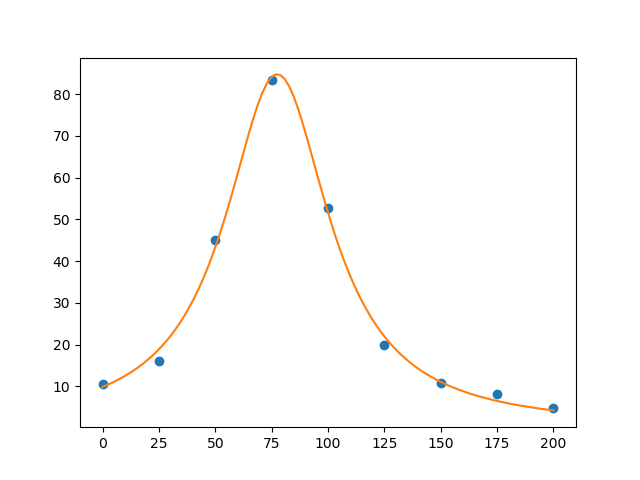

In [25]:
x = np.linspace(0, 200, 100)
t =lorentzian(x, p1)

plt.figure()
plt.plot(data_x,data_y, 'o')
plt.plot(x,t)

▶ **CHECKPOINT 3**